# AIS Library Tutorial

The purpose of this notebook is to provide a comprehensive/practical tutorial on how to use the developed AIS library. In particular, we will show how the developed AIS library can be utilized to compute expectations with respect to arbitrary target distributions.

In [1]:
import numpy as np
import scipy.stats as sp
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as mvn
import ais_lib as ais

def function_contour(func_eval, xmin=-2, xmax=2, ymin=-2, ymax=2, delta=0.01):
    x,y = np.arange(xmin, xmax, delta),np.arange(ymin, ymax, delta)
    X,Y = np.meshgrid(x,y)
    # Reshape the X,Y axes
    Xtemp = np.reshape(X,[np.prod(X.shape),1])
    Ytemp = np.reshape(Y,[np.prod(Y.shape),1])
    # Evaluate target and reshape
    Ztemp = func_eval(np.array([Xtemp,Ytemp]).T)
    Z = np.reshape(np.asmatrix(Ztemp),[X.shape[0],X.shape[1]])
    # Plot contour
    fig = plt.contourf(X,Y,Z)
    return fig

## Example 1: Multivariate Gaussian Target

Let $\theta\in\mathbb{R}^d$ be a $d$-dimensional random vector on some probability space. Suppose we would like to estimate a target distribution
$$ \tilde\pi(\theta) \propto \mathcal{N}(\theta; \mu_\pi, \Sigma_\pi)$$
where $\mu\in\mathbb{R}^d$ is the target mean vector and $\Sigma_\pi\in\mathbb{R}^{d\times d}$ is the target covariance matrix. Our specific goal is to estimate the normalizing constant $Z_\pi=\int_{-\infty}^\infty \tilde\pi(\theta) d\theta$ and the mean vector $\mu_\pi=\mathbb{E}_\pi[\theta]$. 

Let us set the parameters of the target:

In [42]:
# Set parameters of the target distribution
d_theta = 3                    # dimension 
Z_pi = 100                    # normalizing constant  
mu_pi = np.zeros(d_theta)      # target mean
sigma_pi = 1*np.eye(d_theta) # target covariance matrix 

# Create function handle
target_1 = lambda theta: np.log(Z_pi)+mvn.logpdf(theta, mu_pi, sigma_pi)

We can visualize the target distribution using a contour plot.

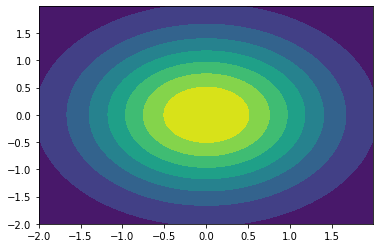

In [43]:
# Define the actual target
temp_target = lambda x: mvn.pdf(x, mu_pi[:2], sigma_pi[:2,:2])
fig1 = function_contour(temp_target)

## Population Monte Carlo (PMC)
We can use the PMC methodology to estimate the above target distribution. The performance of PMC depends on the particular weighting scheme that is chosen. The most basic implementation uses a standard weighting scheme, whereby each particle is weighted according to the ratio of the target and proposal used to generate it.

In [44]:
# Run the stadard PMC 
results_stdPMC = ais.pmc(target_1, d_theta, weighting_scheme='Standard')

100%|██████████| 200/200 [00:00<00:00, 2608.46it/s]


We can use resampling to see how well the methodology approximated the target.

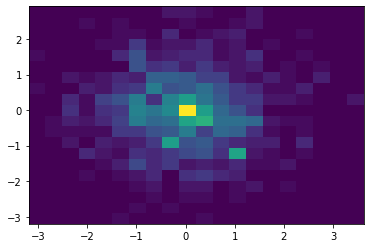

In [45]:
# Extract results
theta = results_stdPMC.particles
log_w = results_stdPMC.log_weights
# Convert log weights to standard weights and normalize
w = np.exp(log_w-np.max(log_w))
wn = w/np.sum(w)
# Sampling importance resampling (SIR) to get approximate posterior samples 
idx = np.random.choice(theta.shape[0], 1000, replace=True, p=wn)
post_samples = theta[idx, :]
# Plot the approximated target using a weighted histogram
fig = plt.hist2d(post_samples[:,0], post_samples[:,1], bins=20)

We can check how well the sampler estimated interesting quantities, such as the normalization constant:

In [46]:
# Total number of samples
M = np.shape(w)[0]
# Obtain estimate of normalization constant correcting for LSE trick
log_Zest = np.log(1/M) + np.max(log_w) + np.log(np.sum(w))
Zest = np.exp(log_Zest)
# Compute mean absolute error in Z
MAEZ_stdPMC = np.abs(Zest-Z_pi)
print('Absolute error in Z (Standard PMC): ',MAEZ_stdPMC)

Absolute error in Z (Standard PMC):  5.010259468312967


We can also use an alternative weighting scheme, called the deterministic mixture (DM) weighting scheme. This weighting scheme weights each particle according to the ratio of the target and the mixture distribution. The mixture distribution is comprised of all proposals used to generate particles in that iteration. This weighting is known to reduce the variance of the AIS esitmator. 

100%|██████████| 200/200 [00:03<00:00, 65.58it/s]


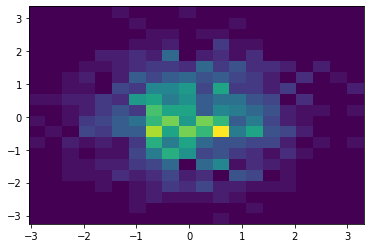

In [47]:
# Run the stadard PMC 
results_DMPMC = ais.pmc(target_1, d_theta, weighting_scheme='DM')
# Extract results
theta = results_DMPMC.particles
log_w = results_DMPMC.log_weights
# Convert log weights to standard weights and normalize
w = np.exp(log_w-np.max(log_w))
wn = w/np.sum(w)
# Sampling importance resampling (SIR) to get approximate posterior samples 
idx = np.random.choice(theta.shape[0], 1000, replace=True, p=wn)
post_samples = theta[idx, :]
# Plot the approximated target using a weighted histogram
fig = plt.hist2d(post_samples[:,0], post_samples[:,1], bins=20)

In [48]:
# Total number of samples
M = np.shape(w)[0]
# Obtain estimate of normalization constant correcting for LSE trick
log_Zest = np.log(1/M) + np.max(log_w) + np.log(np.sum(w))
Zest = np.exp(log_Zest)
# Compute mean absolute error in Z
MAEZ_stdPMC = np.abs(Zest-Z_pi)
print('Absolute error in Z (Standard PMC): ',MAEZ_stdPMC)

Absolute error in Z (Standard PMC):  1.7767847560511711
